In [19]:
import pandas as pd 
import numpy as np 
import glob
import h5py
import tqdm

import matplotlib.pyplot as plt
import scipy.io as sio
sys.path.append('/home/lugeon/eeg_project/scripts')

In [20]:
data_folder = '/mlodata1/yuecetue/eeg-dreams/YuceturkThesis2020/Data'
raw_data_folder = data_folder + '/CHUV/raw'

### Exploration of trials data and samples

#### H patients

In [21]:
n_patients = 0

for file in glob.glob(f'{raw_data_folder}/H*'):
    print(file)
    n_patients += 1

print()
print(f'Number of H patients: {n_patients}')

/mlodata1/yuecetue/eeg-dreams/YuceturkThesis2020/Data/CHUV/raw/H009
/mlodata1/yuecetue/eeg-dreams/YuceturkThesis2020/Data/CHUV/raw/H018
/mlodata1/yuecetue/eeg-dreams/YuceturkThesis2020/Data/CHUV/raw/H019
/mlodata1/yuecetue/eeg-dreams/YuceturkThesis2020/Data/CHUV/raw/H021
/mlodata1/yuecetue/eeg-dreams/YuceturkThesis2020/Data/CHUV/raw/H025
/mlodata1/yuecetue/eeg-dreams/YuceturkThesis2020/Data/CHUV/raw/H026
/mlodata1/yuecetue/eeg-dreams/YuceturkThesis2020/Data/CHUV/raw/H033
/mlodata1/yuecetue/eeg-dreams/YuceturkThesis2020/Data/CHUV/raw/H035
/mlodata1/yuecetue/eeg-dreams/YuceturkThesis2020/Data/CHUV/raw/H048
/mlodata1/yuecetue/eeg-dreams/YuceturkThesis2020/Data/CHUV/raw/H050
/mlodata1/yuecetue/eeg-dreams/YuceturkThesis2020/Data/CHUV/raw/H051
/mlodata1/yuecetue/eeg-dreams/YuceturkThesis2020/Data/CHUV/raw/H054
/mlodata1/yuecetue/eeg-dreams/YuceturkThesis2020/Data/CHUV/raw/H055
/mlodata1/yuecetue/eeg-dreams/YuceturkThesis2020/Data/CHUV/raw/H057
/mlodata1/yuecetue/eeg-dreams/YuceturkThesis2020

In [22]:
n_trials = 0
file_names = []

for file in glob.glob(f'{raw_data_folder}/*/H*.mat'):
    file_names.append(file.split('/')[-1].split('.')[0])
    n_trials += 1

print(f'Number of H trials: {n_trials}')

Number of H trials: 525


In [63]:
with open('temp/h_data.txt', 'w') as file:
    for filename in sorted(glob.glob(f'{raw_data_folder}/*/H*.mat')):
        name = filename.split('/')[-1]
        file.write(f'{name}\n')

In [24]:
df_files = pd.DataFrame({'file_name': file_names})

df_files['split'] = df_files.file_name.apply(lambda f: f.split('_'))
df_files['patient'] = df_files.split.apply(lambda l: l[0])
df_files['experiment'] = df_files.split.apply(lambda l: l[1])
df_files['sleep_stage'] = df_files.split.apply(lambda l: l[2])
df_files['trial'] = df_files.split.apply(lambda l: l[3])

df_files.split.apply(len).value_counts()

4    524
5      1
Name: split, dtype: int64

In [25]:
# There is one trial with unusual file name, it is from 'old' data
df_files[df_files.split.apply(len) == 5]

,file_name,split,patient,experiment,sleep_stage,trial
325,H055_E1_NREM_S02_old,"[H055, E1, NREM, S02, old]",H055,E1,NREM,S02


In [26]:
# There exist a newer version of the data 
df_files[df_files.file_name == 'H055_E1_NREM_S02']

,file_name,split,patient,experiment,sleep_stage,trial
308,H055_E1_NREM_S02,"[H055, E1, NREM, S02]",H055,E1,NREM,S02


In [27]:
# Drop old data
df_files.drop(df_files[df_files.file_name == 'H055_E1_NREM_S02_old'].index, inplace=True)

In [28]:
df_files.patient.value_counts()

H021    40
H099    33
H048    33
H026    32
H068    31
H089    31
H060    31
H050    29
H061    29
H051    29
H033    29
H100    27
H018    25
H054    25
H025    22
H019    19
H055    18
H057    17
H009    14
H035    10
Name: patient, dtype: int64

In [29]:
df_files.experiment.value_counts()

E1    275
E2    249
Name: experiment, dtype: int64

In [30]:
df_files.sleep_stage.value_counts()

NREM    401
REM     123
Name: sleep_stage, dtype: int64

In [31]:
df_files.trial.value_counts()

S07    38
S09    38
S08    38
S01    38
S04    36
S02    36
S05    35
S06    35
S03    34
S12    32
S10    32
S11    31
S13    28
S14    25
S15    15
S16    12
S17    10
S18     6
S19     2
S21     1
S22     1
S20     1
Name: trial, dtype: int64

In [32]:
df_labels = pd.read_excel(f'{data_folder}/Dataset_info/Dream_labels.xlsx')
df_labels.head(), df_labels.shape

(  Subject_id  Quest_number  Stage   CE
 0    H009_E1           1.0    3.0  1.0
 1    H009_E1           2.0    3.0  1.0
 2    H009_E1           3.0    3.0  1.0
 3    H009_E1           4.0    4.0  2.0
 4    H009_E1           5.0    2.0  1.0,
 (527, 4))

In [33]:
df_files['Quest_number'] = df_files.trial.apply(lambda t: int(t[1:]))
df_files['Subject_id'] = df_files.apply(lambda row: f'{row.patient}_{row.experiment}', axis=1)

df_merged = df_files.merge(df_labels, how='outer')

In [34]:
# 5 trials without data
df_merged[df_merged.file_name.isna()]

,file_name,split,patient,experiment,sleep_stage,trial,Quest_number,Subject_id,Stage,CE
524,NaN,NaN,NaN,NaN,NaN,NaN,3.0,H060_E2,3.0,2.0
525,NaN,NaN,NaN,NaN,NaN,NaN,6.0,H061_E1,2.0,2.0
526,NaN,NaN,NaN,NaN,NaN,NaN,10.0,H061_E1,4.0,2.0
527,NaN,NaN,NaN,NaN,NaN,NaN,6.0,H089_E1,2.0,1.0
528,NaN,NaN,NaN,NaN,NaN,NaN,3.0,H100_E2,2.0,0.0


In [67]:
df_merged[df_merged.file_name.isna()][['Quest_number', 'Subject_id', 'Stage', 'CE']].reset_index(drop=True).to_csv('temp/h_data_missing.csv')

In [35]:
# 2 trials without label
df_merged[df_merged.CE.isna()]

,file_name,split,patient,experiment,sleep_stage,trial,Quest_number,Subject_id,Stage,CE
112,H025_E2_NREM_S08,"[H025, E2, NREM, S08]",H025,E2,NREM,S08,8.0,H025_E2,NaN,NaN
341,H057_E1_NREM_S12,"[H057, E1, NREM, S12]",H057,E1,NREM,S12,12.0,H057_E1,NaN,NaN


In [36]:
df_valid = df_merged[(df_merged.CE.notna()) & df_merged.file_name.notna()]

# Number of trials with both data + label
df_valid.shape

(522, 10)

In [37]:
# Maybe the labels are in another file..
df_labels_2 = pd.read_excel(f'{data_folder}/Dataset_info/Dream_reports_healthy.xlsx')

print(df_labels_2[(df_labels_2.Subject_id == 'H025_E2') & (df_labels_2.Quest_number == 8)])
print(df_labels_2[(df_labels_2.Subject_id == 'H057_E1') & (df_labels_2.Quest_number == 12)])

# But there seem to be excluded

    Subject_id  Quest_number  Stage   CE  Segment excluded
159    H025_E2             8      2  2.0                 1
    Subject_id  Quest_number  Stage  CE  Segment excluded
353    H057_E1            12      3 NaN                 1


In [38]:
if False:
    
    sampling_frequency = 500
    recording_time = {}

    for patient in df_valid.patient.drop_duplicates():
        recording_time[patient] = []

    for file_name, patient in tqdm.tqdm(zip(df_valid.file_name, df_valid.patient)):
        with h5py.File(f'{raw_data_folder}/{patient}/{file_name}.mat','r') as file:
            signal_data = np.array(file['datavr'])
            recording_time[patient].append(signal_data.shape[0] / sampling_frequency)

In [39]:
# Stages of sleeping
# 1 -> NREM N1
# 2 -> NREM N2
# 3 -> NREM N3
# 4 -> REM
df_valid.Stage.value_counts() / df_valid.shape[0]

2.0    0.423372
3.0    0.339080
4.0    0.235632
1.0    0.001916
Name: Stage, dtype: float64

In [40]:
# Labels
# 0 -> NE
# 1 -> DE
# 2 -> DEWR
df_valid.CE.value_counts() / df_valid.shape[0]

2.0    0.448276
1.0    0.369732
0.0    0.181992
Name: CE, dtype: float64

In [41]:
df_merged

,file_name,split,patient,experiment,sleep_stage,trial,Quest_number,Subject_id,Stage,CE
0,H009_E1_NREM_S03,"[H009, E1, NREM, S03]",H009,E1,NREM,S03,3.0,H009_E1,3.0,1.0
1,H009_E1_NREM_S05,"[H009, E1, NREM, S05]",H009,E1,NREM,S05,5.0,H009_E1,2.0,1.0
2,H009_E1_NREM_S06,"[H009, E1, NREM, S06]",H009,E1,NREM,S06,6.0,H009_E1,2.0,1.0
3,H009_E1_NREM_S07,"[H009, E1, NREM, S07]",H009,E1,NREM,S07,7.0,H009_E1,2.0,1.0
4,H009_E1_NREM_S09,"[H009, E1, NREM, S09]",H009,E1,NREM,S09,9.0,H009_E1,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...
524,NaN,NaN,NaN,NaN,NaN,NaN,3.0,H060_E2,3.0,2.0
525,NaN,NaN,NaN,NaN,NaN,NaN,6.0,H061_E1,2.0,2.0
526,NaN,NaN,NaN,NaN,NaN,NaN,10.0,H061_E1,4.0,2.0
527,NaN,NaN,NaN,NaN,NaN,NaN,6.0,H089_E1,2.0,1.0


#### M patients

In [69]:
n_patients = 0

for file in glob.glob(f'{raw_data_folder}/M*'):
    print(file)
    n_patients += 1

print()
print(f'Number of M patients: {n_patients}')

/mlodata1/yuecetue/eeg-dreams/YuceturkThesis2020/Data/CHUV/raw/M001
/mlodata1/yuecetue/eeg-dreams/YuceturkThesis2020/Data/CHUV/raw/M002
/mlodata1/yuecetue/eeg-dreams/YuceturkThesis2020/Data/CHUV/raw/M003
/mlodata1/yuecetue/eeg-dreams/YuceturkThesis2020/Data/CHUV/raw/M004
/mlodata1/yuecetue/eeg-dreams/YuceturkThesis2020/Data/CHUV/raw/M005
/mlodata1/yuecetue/eeg-dreams/YuceturkThesis2020/Data/CHUV/raw/M006
/mlodata1/yuecetue/eeg-dreams/YuceturkThesis2020/Data/CHUV/raw/M007

Number of M patients: 7


In [70]:
n_trials = 0
file_names = []

for file in glob.glob(f'{raw_data_folder}/*/M*.mat'):
    file_names.append(file.split('/')[-1].split('.')[0])
    n_trials += 1

print(f'Number of M trials: {n_trials}')

Number of M trials: 784


In [71]:
with open('temp/m_data.txt', 'w') as file:
    for filename in sorted(glob.glob(f'{raw_data_folder}/*/M*.mat')):
        name = filename.split('/')[-1]
        file.write(f'{name}\n')

In [72]:
m_files = pd.DataFrame({'file_name': file_names})

m_files['split'] = m_files.file_name.apply(lambda f: f.split('_'))
m_files['patient'] = m_files.split.apply(lambda l: l[0])
m_files['experiment'] = m_files.split.apply(lambda l: l[1])
m_files['sleep_stage'] = m_files.split.apply(lambda l: l[2])
m_files['trial'] = m_files.split.apply(lambda l: l[3])

m_files.head()

,file_name,split,patient,experiment,sleep_stage,trial
0,M001_E10_NREM_S1,"[M001, E10, NREM, S1]",M001,E10,NREM,S1
1,M001_E10_NREM_S2,"[M001, E10, NREM, S2]",M001,E10,NREM,S2
2,M001_E10_NREM_S4,"[M001, E10, NREM, S4]",M001,E10,NREM,S4
3,M001_E10_NREM_S6,"[M001, E10, NREM, S6]",M001,E10,NREM,S6
4,M001_E10_REM_S3,"[M001, E10, REM, S3]",M001,E10,REM,S3


In [73]:
m_files.split.apply(len).value_counts()

4    784
Name: split, dtype: int64

In [74]:
m_labels = pd.read_excel(f'{data_folder}/Dataset_info/Madison_labels.xlsx')
m_labels.rename(columns={'Unnamed: 0': 'Subject_id'}, inplace=True)

In [75]:
m_labels.head(), m_labels.shape

(  Subject_id  Quest_number  Stage   CE
 0    M001_E1           1.0    0.0  0.0
 1    M001_E1           2.0    2.0  2.0
 2    M001_E1           3.0    0.0  2.0
 3    M001_E1           4.0    2.0  2.0
 4    M001_E1           5.0    0.0  2.0,
 (795, 4))

In [76]:
m_files['Quest_number'] = m_files.trial.apply(lambda t: int(t[1:]))
m_files['Subject_id'] = m_files.apply(lambda row: f'{row.patient}_{row.experiment}', axis=1)

m_merged = m_files.merge(m_labels, how='outer')

m_merged.isna().sum()

file_name       11
split           11
patient         11
experiment      11
sleep_stage     11
trial           11
Quest_number     0
Subject_id       0
Stage            0
CE               0
dtype: int64

In [77]:
m_merged[m_merged.file_name.isna()][['Quest_number', 'Subject_id', 'Stage', 'CE']].reset_index(drop=True).to_csv('temp/m_data_missing.csv')

In [29]:
# 784 trials with data + labels
m_valid = m_merged[m_merged.file_name.notna()]
m_valid.shape

(784, 10)

In [30]:
# Check content of one M file
mat = sio.loadmat(f'{raw_data_folder}/M001/M001_E10_NREM_S1.mat')
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon May 11 18:46:33 2020',
 '__version__': '1.0',
 '__globals__': [],
 'chanlocs': array([[nan]]),
 'datavr_2min': array([[19.108366 , 14.476612 , 15.880455 , ...,  8.616664 , 17.811193 ,
         12.5544195],
        [16.30928  , 11.74499  , 12.751625 , ...,  6.50291  , 14.731307 ,
          9.74994  ],
        [14.549137 , 11.425933 , 11.290257 , ...,  7.271951 , 12.117438 ,
          7.941881 ],
        ...,
        [29.40664  , 26.687326 , 27.536587 , ...,  3.2959204,  8.945313 ,
          3.1859741],
        [29.665884 , 26.503073 , 27.61386  , ...,  1.5830936,  8.182848 ,
          2.4125326],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
          0.       ]], dtype=float32),
 'srate': array([[500]], dtype=uint16)}

In [31]:
mat['datavr_2min'].shape

(257, 60000)

In [32]:
mat['datavr_2min'].shape[1] / 500 # 120 seconds

120.0

In [33]:
m_valid

,file_name,split,patient,experiment,sleep_stage,trial,Quest_number,Subject_id,Stage,CE
0,M001_E10_NREM_S1,"[M001, E10, NREM, S1]",M001,E10,NREM,S1,1.0,M001_E10,3.0,2.0
1,M001_E10_NREM_S2,"[M001, E10, NREM, S2]",M001,E10,NREM,S2,2.0,M001_E10,3.0,0.0
2,M001_E10_NREM_S4,"[M001, E10, NREM, S4]",M001,E10,NREM,S4,4.0,M001_E10,3.0,0.0
3,M001_E10_NREM_S6,"[M001, E10, NREM, S6]",M001,E10,NREM,S6,6.0,M001_E10,3.0,2.0
4,M001_E10_REM_S3,"[M001, E10, REM, S3]",M001,E10,REM,S3,3.0,M001_E10,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...
779,M007_E6_NREM_S7,"[M007, E6, NREM, S7]",M007,E6,NREM,S7,7.0,M007_E6,2.0,0.0
780,M007_E6_NREM_S9,"[M007, E6, NREM, S9]",M007,E6,NREM,S9,9.0,M007_E6,3.0,0.0
781,M007_E6_REM_S12,"[M007, E6, REM, S12]",M007,E6,REM,S12,12.0,M007_E6,4.0,2.0
782,M007_E6_REM_S15,"[M007, E6, REM, S15]",M007,E6,REM,S15,15.0,M007_E6,4.0,2.0


In [34]:
m_valid.sleep_stage.value_counts()

NREM    610
REM     134
WAKE     40
Name: sleep_stage, dtype: int64

In [35]:
m_valid.Stage.value_counts() / m_valid.shape[0]

2.0    0.427296
3.0    0.329082
4.0    0.170918
0.0    0.051020
1.0    0.021684
Name: Stage, dtype: float64

#### Baseline

In [56]:
pd.read_csv(f'{data_folder}/CHUV/DataBaseline/rawdb_info.csv')

,file_path,file_name,subject,stage,trial_num
0,H009/REM_c3.mat,REM_c3.mat,H009,REM,c3.mat
1,H009/REM_c4.mat,REM_c4.mat,H009,REM,c4.mat
2,H009/NREM_c1.mat,NREM_c1.mat,H009,NREM,c1.mat
3,H009/NREM_c2.mat,NREM_c2.mat,H009,NREM,c2.mat
4,H009/NREM_c3.mat,NREM_c3.mat,H009,NREM,c3.mat
...,...,...,...,...,...
156,H061/REM_c1.mat,REM_c1.mat,H061,REM,c1.mat
157,H061/REM_c2.mat,REM_c2.mat,H061,REM,c2.mat
158,H061/REM_c3.mat,REM_c3.mat,H061,REM,c3.mat
159,H061/REM_c4.mat,REM_c4.mat,H061,REM,c4.mat


In [47]:
n_patients = 0

for file in glob.glob(f'{data_folder}/CHUV/DataBaseline/H*'):
    n_patients += 1

print()
print(f'Number of baseline patients: {n_patients}')


Number of baseline patients: 14


In [54]:
n_trials = 0
file_names = []

for file in glob.glob(f'{data_folder}/CHUV/DataBaseline/H*/*.mat'):
    file_names.append(file.split('/')[-1].split('.')[0])
    n_trials += 1

print(f'Number of baseline trials: {n_trials}')

Number of baseline trials: 161


In [61]:
with open('temp/baseline_h_data.txt', 'w') as file:
    for filename in sorted(glob.glob(f'{data_folder}/CHUV/DataBaseline/H*/*.mat')):
        name = filename.split('/')[-2:]
        file.write(f'{name[0]}/{name[1]}\n')

In [49]:
# Content of one baseline file
with h5py.File(f'{data_folder}/CHUV/DataBaseline/H009/REM_c3.mat','r') as file:
    signal_data = np.array(file['datavr'])

signal_data.shape

(540000, 257)

In [52]:
signal_data.shape[0] / 500 / 60 # 18 minutes

18.0

In [53]:
n_samples = 0

for file_path in tqdm.tqdm(glob.glob(f'{data_folder}/CHUV/DataBaseline/H009/*.mat')):
    with h5py.File(file_path,'r') as file:
        signal_data = np.array(file['datavr'])
        n_samples += signal_data.shape[0]

n_samples / 500 / 60 # length in minutes for one baseline subject

100%|██████████| 8/8 [06:40<00:00, 50.04s/it]


385.0

In [40]:
# There is also a file containing other info about baseline recording
with h5py.File(f'{data_folder}/CHUV/DataBaseline/Info/H009/INFO_REM_c3.mat','r') as file:
    for k, v in file.items():
        print(k)

cepo
cpoints
id_epo
orig_fs
pt_arousals
scoring


### Further exploration of raw data file

In [41]:
import h5py

file_path = f'{raw_data_folder}/H009/H009_E1_NREM_S01.mat'
with h5py.File(file_path,'r') as file:
    for k, v in file.items():
        print(k)

#refs#
chanlocs
condi
datavr
events
numseg
ordseg
reactime
srate
stage
subject


In [42]:
with h5py.File(file_path,'r') as file:
    signal_data = np.array(file['datavr'])

In [43]:
signal_data.shape

(394125, 257)

In [44]:
signal_data[:, 0].mean(), signal_data[:, 0].std()

(0.2243921, 27.815733)

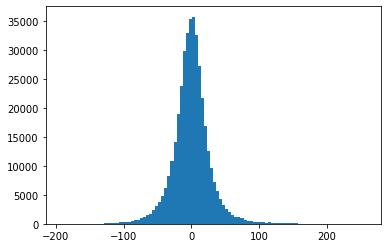

In [45]:
plt.hist(signal_data[:, 0], bins=100);

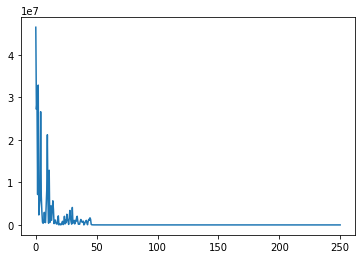

In [46]:
sampling_frequency = 500
signal = signal_data[:sampling_frequency * 2, 0]

ps = np.abs(np.fft.rfft(signal))**2

time_step = 1 / sampling_frequency
freqs = np.fft.rfftfreq(signal.size, time_step)

plt.plot(freqs, ps);

In [47]:
real_fft = np.abs(np.fft.rfft(signal))
complex_fft = np.abs(np.fft.fft(signal))

In [48]:
2 * real_fft[1:].sum() + real_fft[0], complex_fft.sum()

(253880.05075708264, 253878.7674220712)

### Comparison with existing data

In [49]:
from preprocessing.frequency_transform import compute_bandwidths_power

In [50]:
fft_data = sio.loadmat(f'{data_folder}/FFT_all_bands_120s/H009_FFT/H009_E1_NREM_S01_FFT.mat')
for k, v in fft_data.items():
    print(k)

__header__
__version__
__globals__
alpha
beta
delta
gamma
rest
theta


In [51]:
fft_data['delta'], fft_data['delta'].shape

(array([[ 70.03540039,  54.10562515,  26.66328239, ...,  98.33313751,
          85.58564758, 155.87760925],
        [ 84.72238159,  69.39164734,  47.78038788, ..., 105.12575531,
         113.3421936 , 163.82183838],
        [103.04844666,  79.75418854,  68.64001465, ..., 105.89842987,
         154.28872681, 176.68569946],
        ...,
        [ 51.48116684,  52.13946915,  45.64640045, ..., 107.45292664,
         138.48443604, 108.14183044],
        [ 38.30952454,  34.35255432,  28.58793831, ...,  69.69562531,
          97.65805054,  83.32487488],
        [155.80851746,  79.09558105, 120.78317261, ..., 233.45315552,
         402.22149658, 417.32052612]]),
 (257, 237))

In [52]:
time_period = 120
sampling_frequency = 500

time_window = 2
time_shift = .5

bandwiths = np.array([
    [1, 4]
])

eeg_power = compute_bandwidths_power(signal_data, sampling_frequency, time_period, time_window, time_shift, bandwiths)
eeg_power.shape

(237, 256, 1)

In [53]:
eeg_power[:, :, 0].T

array([[ 70.0478204 ,  54.18062688,  26.7485976 , ...,  97.97971129,
         85.2308798 , 155.38274645],
       [ 84.84533528,  69.60938264,  48.04652812, ..., 105.10672241,
        113.53858222, 163.92818408],
       [103.24880539,  80.07914123,  69.06882373, ..., 106.38020443,
        155.15035795, 177.47143698],
       ...,
       [ 37.9508243 ,  38.1264379 ,  35.22826   , ...,  75.73853365,
         99.49108342,  82.25947262],
       [ 51.05797293,  51.79019696,  45.33440864, ..., 106.37207647,
        136.81105489, 106.62719415],
       [ 37.92575146,  34.0388442 ,  28.26321573, ...,  68.8241211 ,
         96.24480916,  82.00289727]])